In [3]:
import numpy as np
import cv2
from scipy.sparse import spdiags, linalg
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.dpi'] = 120

In [4]:
img1 = cv2.imread('images/1.bmp')
img2 = cv2.imread('images/2.bmp')
img3 = cv2.imread('images/3.bmp')
img4 = cv2.imread('images/4.jpg')
img5 = cv2.imread('images/5.jpg')
img6 = cv2.imread('images/6.jpg')
img7 = cv2.imread('images/7.jpg')
img8 = cv2.imread('images/8.jpg')
img9 = cv2.imread('images/9.jpg')
img10 =  cv2.imread('images/10.png')


In [5]:
def atmospheric_light(x):
    M = x.shape[0]
    N = x.shape[1]
    flat_img = x.reshape(M * N, 3)
    flat_min_channel = np.amin(x, axis=2).ravel()
    indices = np.argpartition(flat_min_channel, 4)
    AtLight = np.amax(np.take(flat_img, indices, axis=0), axis=0)
    return AtLight

def dark_channel(x, patch_size=7):
    atl = atmospheric_light(x)
    
    x_m_b = x[:, :, 0] / atl[0]
    x_m_g = x[:, :, 1] / atl[1]
    x_m_r = x[:, :, 2] / atl[2]
    
    s_x_m = np.stack([x_m_b, x_m_g, x_m_r], axis=-1)
    min_channel = np.amin(s_x_m, axis=2)
    se = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(patch_size, patch_size))
    dc = cv2.erode(min_channel, se)
    return dc

def wls(x, gamma=2048, theta=13/8, EPS=1/64):
        height, width = x.shape[0 : 2]
        size = height * width
        log_x = np.log(x + EPS)

        dy = np.diff(a=log_x, n=1, axis=0)
        dy = - gamma / (np.abs(dy) ** theta + EPS)
        dy = np.pad(array=dy, pad_width=((0, 1), (0, 0)), mode="constant")
        dy = dy.ravel()

        dx = np.diff(a=log_x, n=1, axis=1)
        dx = - gamma / (np.abs(dx) ** theta + EPS)
        dx = np.pad(array=dx, pad_width=((0, 0), (0, 1)), mode="constant")
        dx = dx.ravel()

        diff_stack = np.vstack((dy, dx))
        a = spdiags(data=diff_stack, diags=[-width, -1], m=size, n=size)

        w = np.pad(array=dy, pad_width=(width, 0), mode="constant")
        w = w[: -width]
        h = np.pad(array=dx, pad_width=(1, 0), mode="constant")
        h = h[: -1]

        diag = 1 - (dx + w + dy + h)
        a = a + a.transpose() + spdiags(data=diag, diags=0, m=size, n=size)

        out, _ = linalg.cg(A=a, b=x.ravel())
        out = out.reshape((height, width))
        return out

def transmission_map(x):
    t = (1 - wls(dark_channel(x))).astype(np.float32)
    return t

def scene_radiance(x):
    atmosphere = atmospheric_light(x)
    trans = transmission_map(x)[:, :, None]
    img = np.float64(x)
    return np.uint8(((x - atmosphere) / trans + atmosphere).clip(0, 255))


def display(haze_img, file_name):
    v = scene_radiance(haze_img)
    d = dark_channel(haze_img)

    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(haze_img, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('haze image', fontsize=7)
    plt.subplot(132)
    plt.imshow(d, cmap='gray'), plt.axis('off'), plt.title('dark channel', fontsize=7)
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('de-hazed image', fontsize=7)
    plt.savefig(f'{file_name}', bbox_inches='tight')
    plt.show()


In [ ]:
display(img1, 'result1')

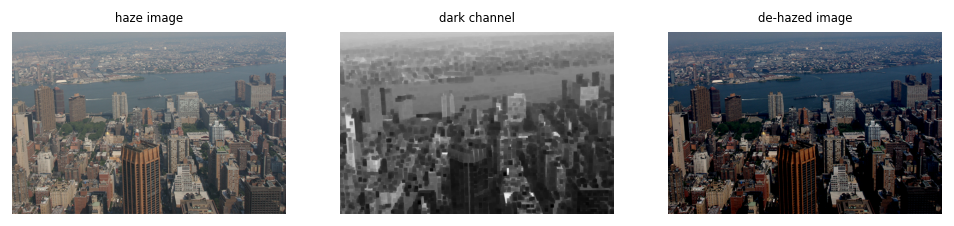

In [5]:
display(img2, 'result2')

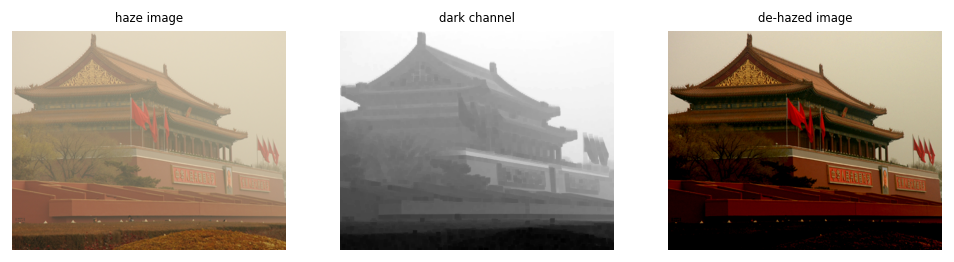

In [6]:
display(img3, 'result3')

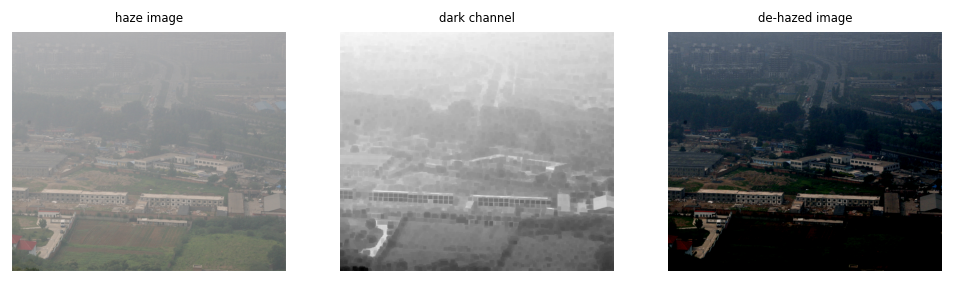

In [7]:
display(img4, 'result4')

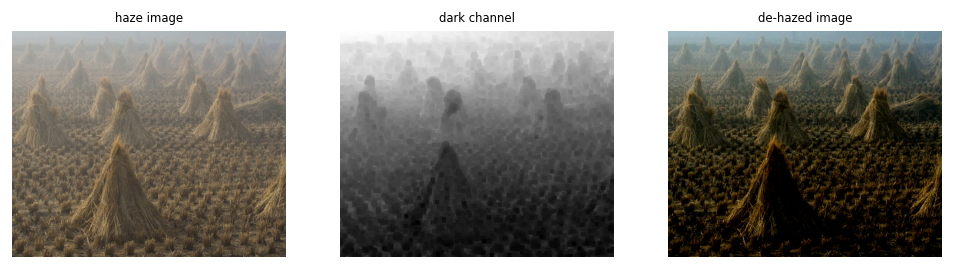

In [8]:
display(img5, 'result5')

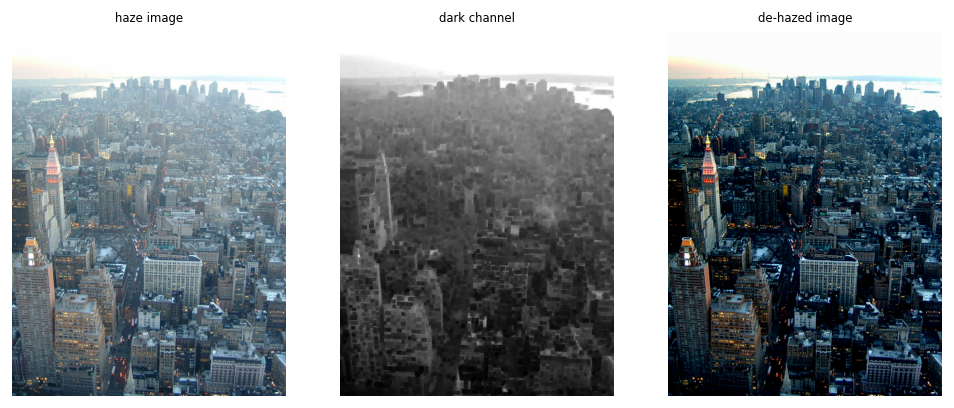

In [9]:
display(img6, 'result6')

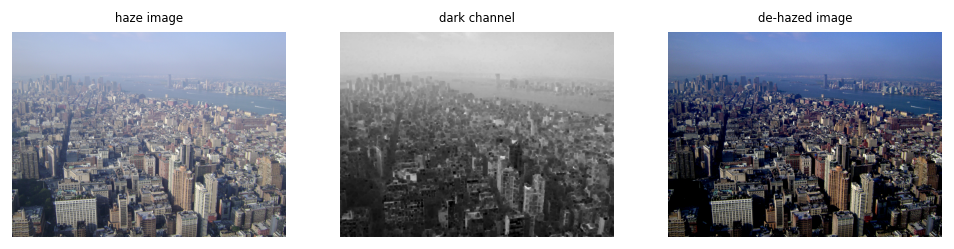

In [10]:
display(img7, 'result7')

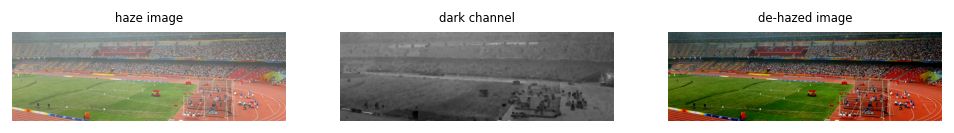

In [11]:
display(img8, 'result8')

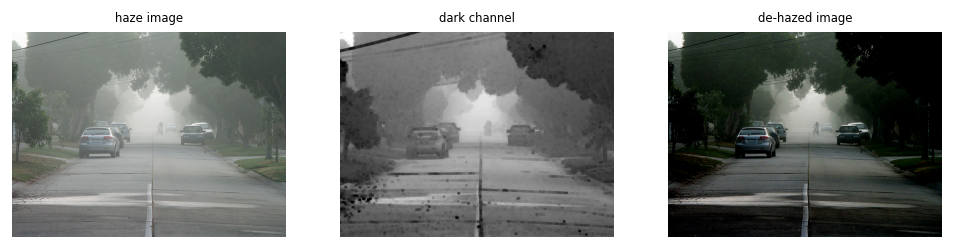

In [12]:
display(img9, 'result9')

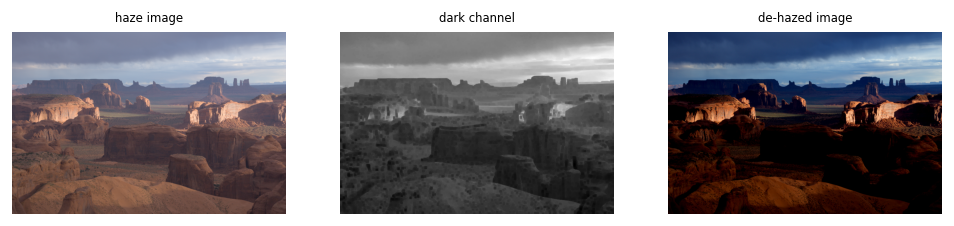

In [13]:
display(img10, 'result10')